## Getting Started With Geospatial Data Analysis 

This notebook covers the basics of getting started with Geospatial Data Analysis on SageMaker Studio. We start with exploring the sentinel geospatial dataset available at AWS open data registry. We explore deforestation data by analyzing [Sentinel-2](https://registry.opendata.aws/sentinel-2/) geospatial data and calculating spectral indices. Below is the example of Paradise California. Similar concept will be used to identified forest cut temporal detection. 

## Install Packages (Optional)

Creating a environment in Studio is easy, by default sagemaker will have conda environment installed. you can use 'pip install' commands to to install required packages
below are the all the required packages for this workshop 
you only needs to install package first time when you create any notebook

In [ ]:
%pip install pandas
%pip install numpy
%pip install geopandas
#%pip install shapely
%pip install matplotlib
#%pip install plotly_express
%pip install sentinelhub
%pip install rasterio
#%pip install utils
#%pip install folium
%pip install earthpy
%pip install awswrangler

## Import Packages

After the environment is created and selected or the packages installed manually, we can import them directly.

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
#import folium
#import plotly_express as px
import os
import warnings
import datetime
import json
import boto3
import gc
import rasterio as rio
import os
import earthpy.spatial as es
import earthpy.plot as ep
import imageio
import io
import awswrangler as wr
import json

%matplotlib inline
warnings.filterwarnings('ignore')

## Working With Geospatial Images

For Geospatial data, we will use Sentinel-2. The [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) is a land monitoring constellation of two satellites that provide high resolution optical imagery and continuity for the current SPOT and Landsat missions. The Sentinel-2 dataset is available publicly at the [AWS open data registry](https://registry.opendata.aws/sentinel-2/).

We will use the [sentinelhub python package](https://sentinelhub-py.readthedocs.io/en/latest/), that makes it easy to search and download data specific to our focus area directly from AWS.

In [3]:
from sentinelhub import (
    MimeType,
    CRS,
    BBox,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    DataCollection,
    bbox_to_dimensions,
    DownloadRequest
)

## Sentinel Hub Setup

This section shows how to configure your credentials for sentinelhub. We are using a optional json file to store and retrieve credentials.

We need Setinelhub instance_id and AWS Key and Access ID as requester pays the transfer fees.


In [4]:
from sentinelhub import SHConfig
config = SHConfig()

with open("config_new.json") as json_data_file:
    cfg = json.load(json_data_file)
    
# instance_id - Instance ID from from your Sentinel Hub account 
config.instance_id = cfg["sentinelhub"]["instance_id"]

config.save()
# Verify credentials

from sentinelhub import WebFeatureService, BBox, CRS, DataCollection, SHConfig
if config.instance_id == '':
    print("Warning! To use WFS functionality, please configure the `instance_id`.")

## Data Search 

Before we download, we need to specify our search coordinates that we want to study and the time window. In our case we are focusing on the Paradise, CA region, which we specify as a bounding box and a random time period.

In [5]:
# Specify bounding box and time interval for search

#california paradise after fire
search_bbox = BBox(bbox=[-121.666536,39.708771,-121.542266,39.792182],crs=CRS.WGS84)
#before fire
#search_time_interval = ('2018-11-01T00:00:00', '2018-11-01T23:59:59')
#after fire
search_time_interval = ('2019-01-10T00:00:00', '2019-01-10T23:59:59')

wfs_iterator = WebFeatureService(
    search_bbox,
    search_time_interval,
    data_collection=DataCollection.SENTINEL2_L1C,
    maxcc=0.6,
    config=config
)

for tile_info in wfs_iterator:
    print(tile_info)


{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[-121.83283052717692, 39.74439076989258], [-121.84911612911866, 38.755207234120164], [-120.58625091211863, 38.735945671262385], [-120.55212699833123, 39.72444308454406], [-121.83283052717692, 39.74439076989258]]]]}, 'properties': {'id': 'S2A_OPER_MSI_L1C_TL_SGS__20190110T204028_A018557_T10SFJ_N02.07', 'date': '2019-01-10', 'time': '19:03:32', 'path': 's3://sentinel-s2-l1c/tiles/10/S/FJ/2019/1/10/0', 'crs': 'EPSG:32610', 'mbr': '600000,4290240 709800,4400040', 'cloudCoverPercentage': 26.35}}
{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[-121.8172887117506, 40.64479052115527], [-121.83432267419568, 39.65576614324947], [-120.55525350180832, 39.63588071672625], [-120.51956282354229, 40.62420116172801], [-121.8172887117506, 40.64479

In [6]:
##before fire bucket - s3://sentinel-s2-l1c/tiles/10/T/FK/2018/11/1/0
##after fire bucket - s3://sentinel-s2-l1c/tiles/10/T/FK/2019/1/10/0

## Working With Geospatial Images

For Geospatial data, we will use Sentinel-2. The [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) is a land monitoring constellation of two satellites that provide high resolution optical imagery and continuity for the current SPOT and Landsat missions. The Sentinel-2 dataset is available publicly at the [AWS open data registry](https://registry.opendata.aws/sentinel-2/).

The Sentinel-2 satellites each carry a single multi-spectral instrument (MSI) with 13 spectral channels in the visible/near infrared (VNIR) and short wave infrared spectral range (SWIR). You can read more about these bands [here](https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands). 


Here is the table of the bands captured by Sentinel-2

|Band|Resolution|Description|
|---|---|---|
|B1	|60 m	|Ultra Blue (Coastal and Aerosol)|
|B2	|10 m	|Blue|
|B3	|10 m	|Green|
|B4	|10 m	|Red|
|B5	|20 m	|Visible and Near Infrared (VNIR)|
|B6	|20 m	|Visible and Near Infrared (VNIR)|
|B7	|20 m	|Visible and Near Infrared (VNIR)|
|B8	|10 m	|Visible and Near Infrared (VNIR)|
|B8a|20 m	|Visible and Near Infrared (VNIR)|
|B9	|60 m	|Short Wave Infrared (SWIR)|
|B10|60 m	|Short Wave Infrared (SWIR)|
|B11|20 m	|Short Wave Infrared (SWIR)|
|B12|20 m	|Short Wave Infrared (SWIR)|

## Working with Raster Data

Geospatial data is essentially comprised of raster data or vector data. Sentinel-2 uses GeoTIFF, a gridded raster datasets for satellite imagery and terrain models. [Rasterio is a Python library](https://rasterio.readthedocs.io/en/latest/) that allows to read, inspect, visualize and write geospatial raster data. Here we use rasterio to read thee raster arrays and then use this data to create a true color image.

In [7]:
from rasterio import plot
from rasterio.plot import show
from rasterio.session import AWSSession
from rasterio.windows import Window

we will be using AWSSession object to mark requester_pays true for requesting file directly from sentinel 

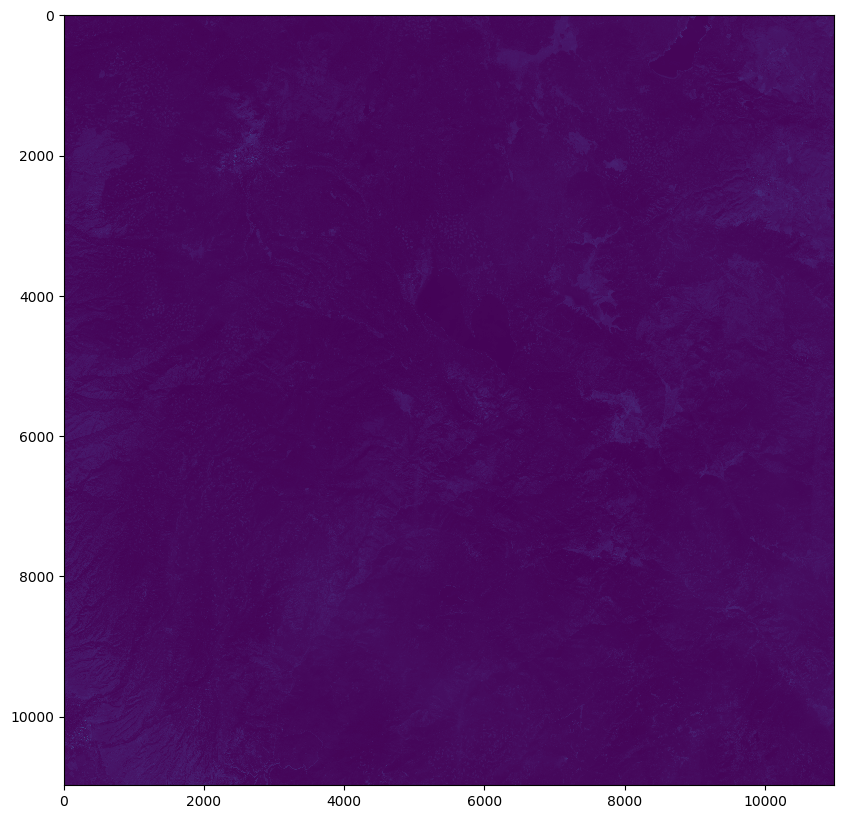

In [8]:

aws_session = AWSSession(boto3.Session(), requester_pays=True)
with rio.Env(aws_session):
    with rio.open('s3://sentinel-s2-l1c/tiles/10/T/FK/2018/11/1/0/B04.jp2') as src:
        red = src.read()
    plt.figure(figsize=[10,10],num=1, clear=True)
    show(red) #RdYlGn
    plt.show()

as you can see its very dark image and we cannot see but lets change some contrast in color mode to make it better for human eye

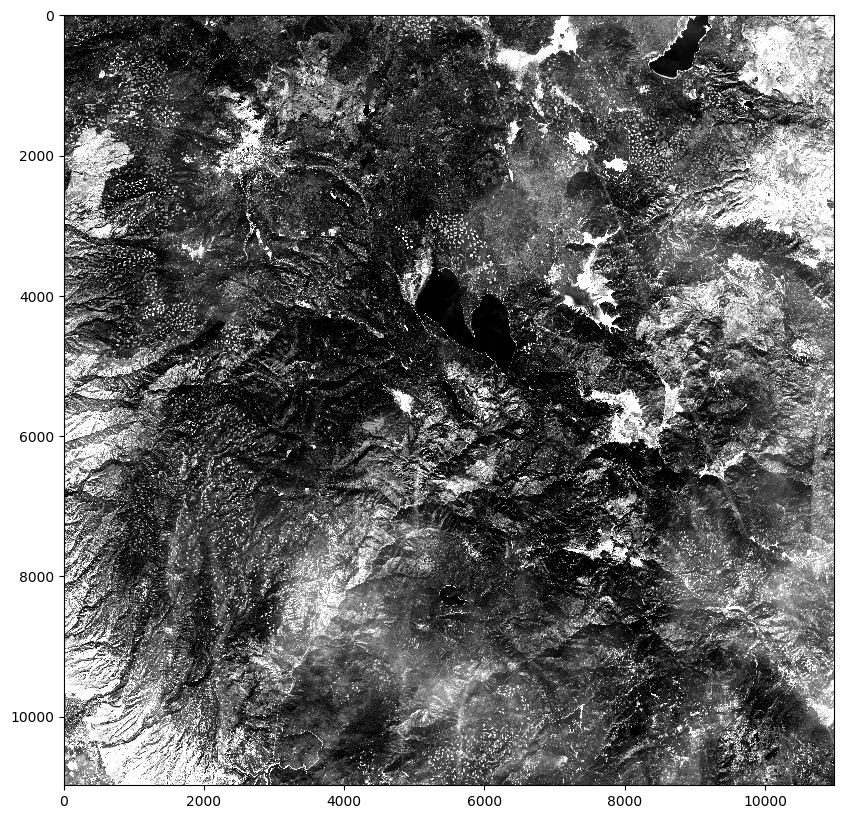

In [9]:
vmin, vmax = np.nanpercentile(red, (5,95))  # 5-95% contrast stretch
plt.figure(figsize=[10,10])
show(red, cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

now lets see near infrared image with different color scheme 

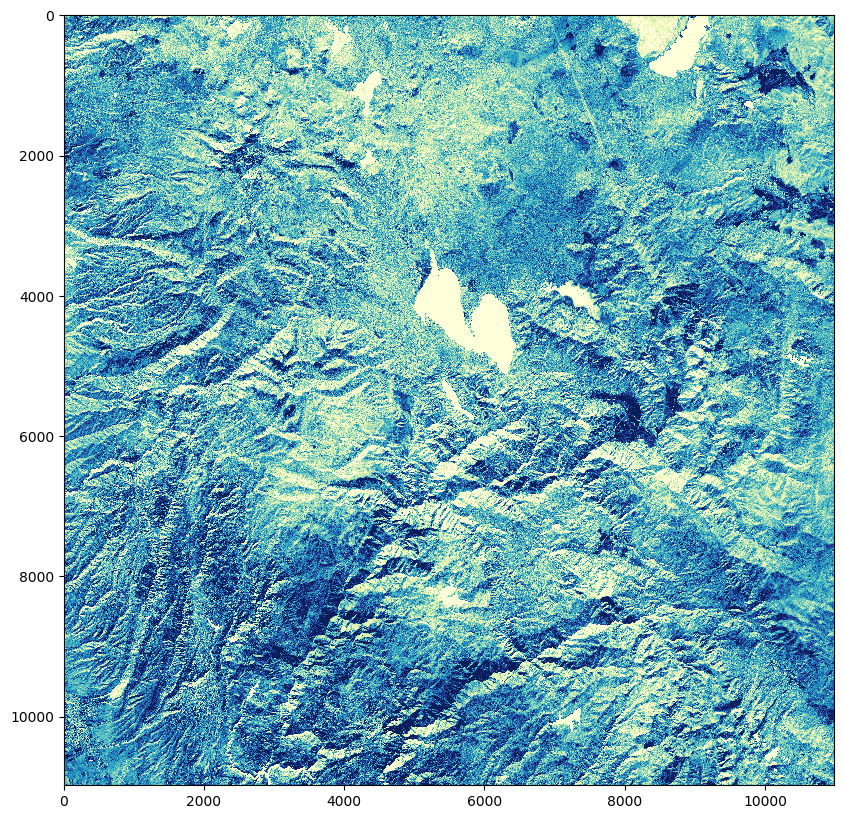

In [10]:
aws_session = AWSSession(boto3.Session(), requester_pays=True)
with rio.Env(aws_session):
    with rio.open('s3://sentinel-s2-l1c/tiles/10/T/FK/2018/11/1/0/B08.jp2') as src:
        nir = src.read()

    
vmin, vmax = np.nanpercentile(nir, (5,95))  # 5-95% contrast stretch    
plt.figure(figsize=[10,10],num=1, clear=True)
show(nir, cmap='YlGnBu', vmin=vmin, vmax=vmax) #RdYlGn #YlGnBu
plt.show()


## Calculating Spectral Indices

Spectral indices are combinations of the pixel values from two or more spectral bands in a multispectral image. Spectral indices highlight pixels showing the relative abundance or lack of a land-cover type of interest in an image. Let's looks at a couple Wikipedia: [source](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index), visual example: [source](https://gisgeography.com/sentinel-2-bands-combinations/) 

## Normalized Difference Vegetation Index - NDVI

The normalized difference vegetation index is a simple graphical indicator that can be used to analyze whether or not the target being observed contains live green vegetation.
near-infrared (which vegetation strongly reflects) and red light (which vegetation absorbs), the vegetation index is good for quantifying the amount of vegetation. The formula for the normalized difference vegetation index is (B8-B4)/(B8+B4). While high values suggest dense canopy, low or negative values indicate urban and water features.

It calculated as NDVI = (B8 - B4) /(B8 + B4) or (NIR – Red) / (NIR + Red)


## Moisture Index 
The Moisture index is ideal for finding water stress in plants. It uses the short-wave and near-infrared to generate an index of moisture content. In general, wetter vegetation has higher values. But lower moisture index values suggest plants are under stress from insufficient moisture.

It calculated as (B8A - B11) / (B8A + B11)


Now that we already have processed B4 and B8 bands we can calculate Normalized Difference Vegetation Index 

In [11]:
#It calculated as NDVI = (B8 - B4) /(B8 + B4) or (NIR – Red) / (NIR + Red)
ndvisample = (nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float))

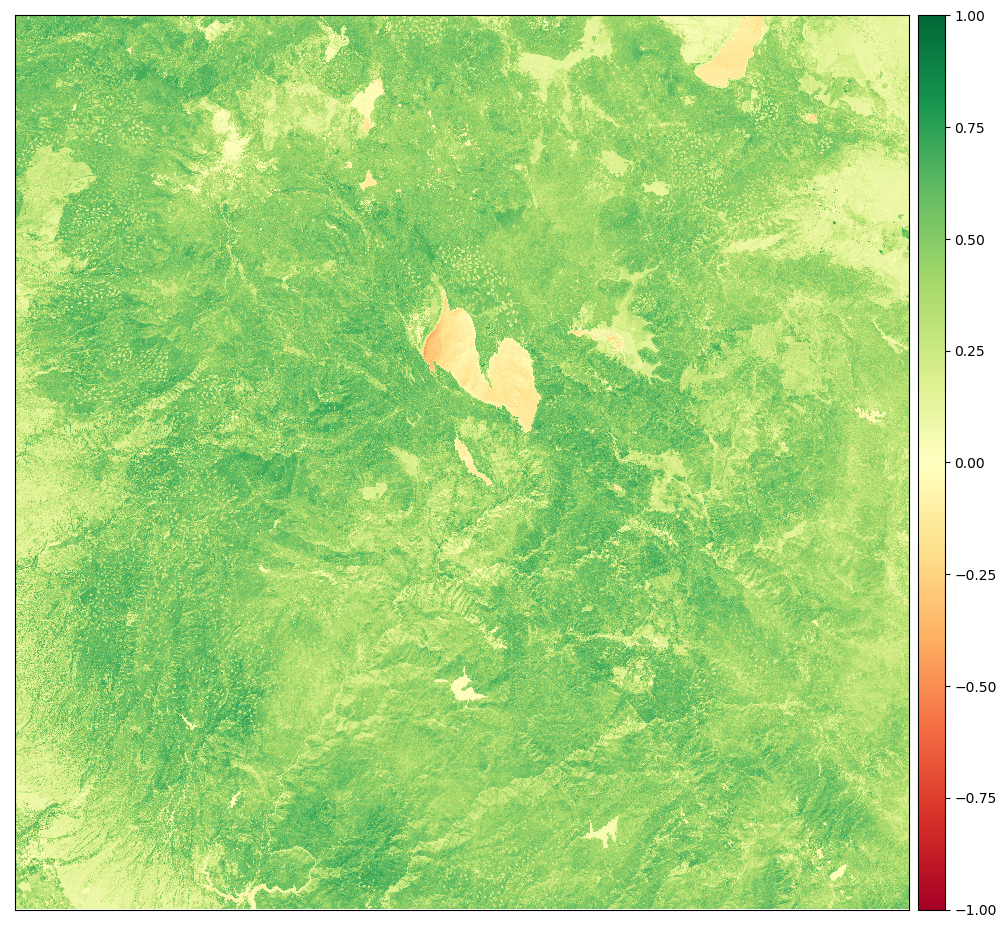

In [12]:
#we are using earthpy to visualize NDVI
ep.plot_bands(ndvisample, cmap="RdYlGn", vmin=-1, vmax=1);

now lets process the image from one year the above image (after paradise fire) 

In [13]:
#clean up memory if processes talking a lot of memory 
#del red 
#del nir 
#del ndvisample
#gc.collect()

The above visualization shows us the classification of deforestation  plotted for region. You can see the dense forest area in dark green and dead forest or no forest in contrasting shades.

Now Lets classify these spectrum into different bins and utilize earthpy to visualize the same. The [earthpy](https://earthpy.readthedocs.io/en/latest/) package allows easy plotting of visualization of bands, we use it here to visualize the Normalized Difference Vegetation index around the selected region.

In [14]:
# Create classes and apply to NDVI results
ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_density_class = np.digitize(ndvisample, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_density_class = np.ma.masked_where(
    np.ma.getmask(ndvisample), ndvi_density_class
)
np.unique(ndvi_density_class)

masked_array(data=[1, 2, 3, 4, 5],
             mask=False,
       fill_value=999999)

In [15]:
from matplotlib.colors import ListedColormap
# Define color map
nbr_colors = ["khaki", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "Dead forest",
    "Scrub",
    "Open Forest",
    "Moderately Dense Forest",
    "Very Dense Forest",
]

# Get list of classes
classes = np.unique(ndvi_density_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:5]


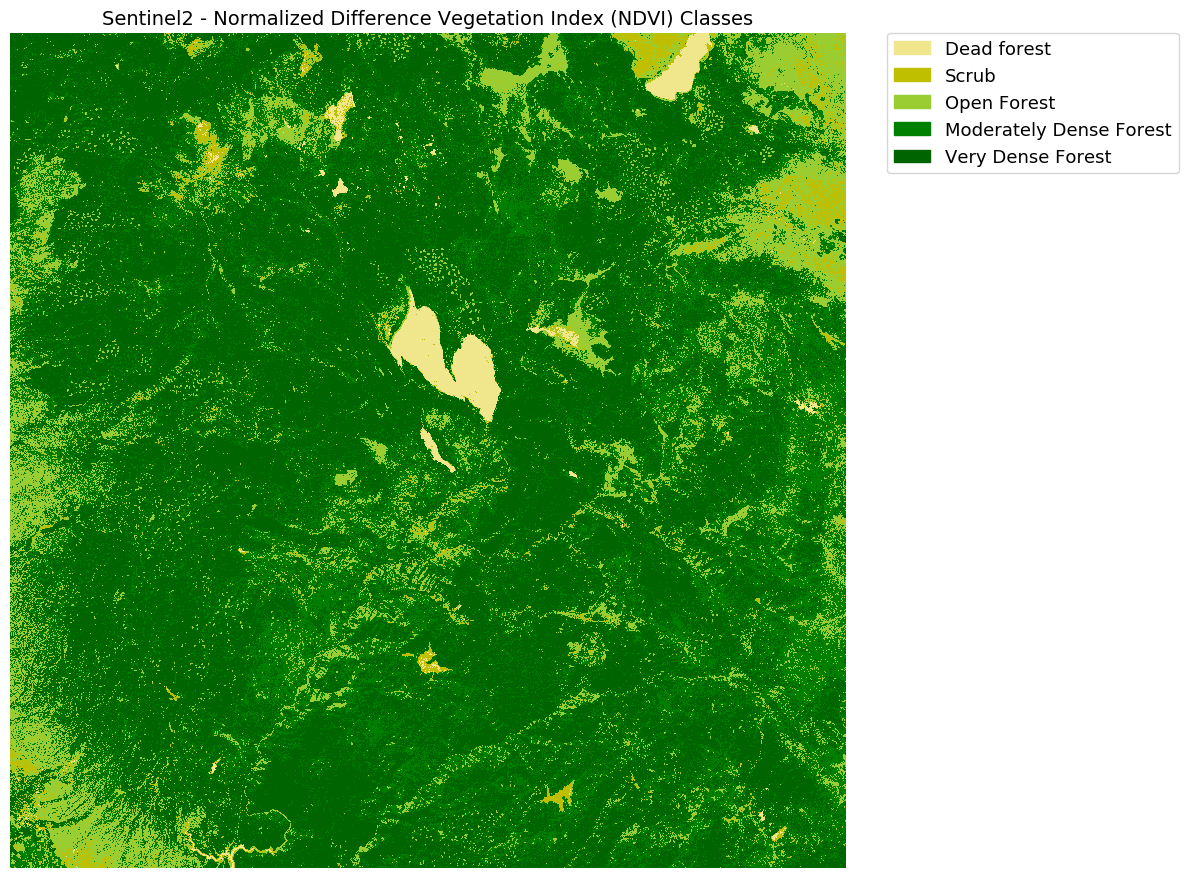

In [16]:
# Plot your data

fig, (ax1) = plt.subplots(1, figsize=(12, 12), num=1, clear=True)
im1 = ax1.imshow(np.squeeze(ndvi_density_class), cmap=nbr_cmap)
ep.draw_legend(im_ax=im1, classes=classes, titles=ndvi_cat_names)
ax1.set_title(
    "Sentinel2 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)

ax1.set_axis_off()
plt.tight_layout()

In this image you can see different forest cluster from 'Very Dense Forest' to 'Dead forest'

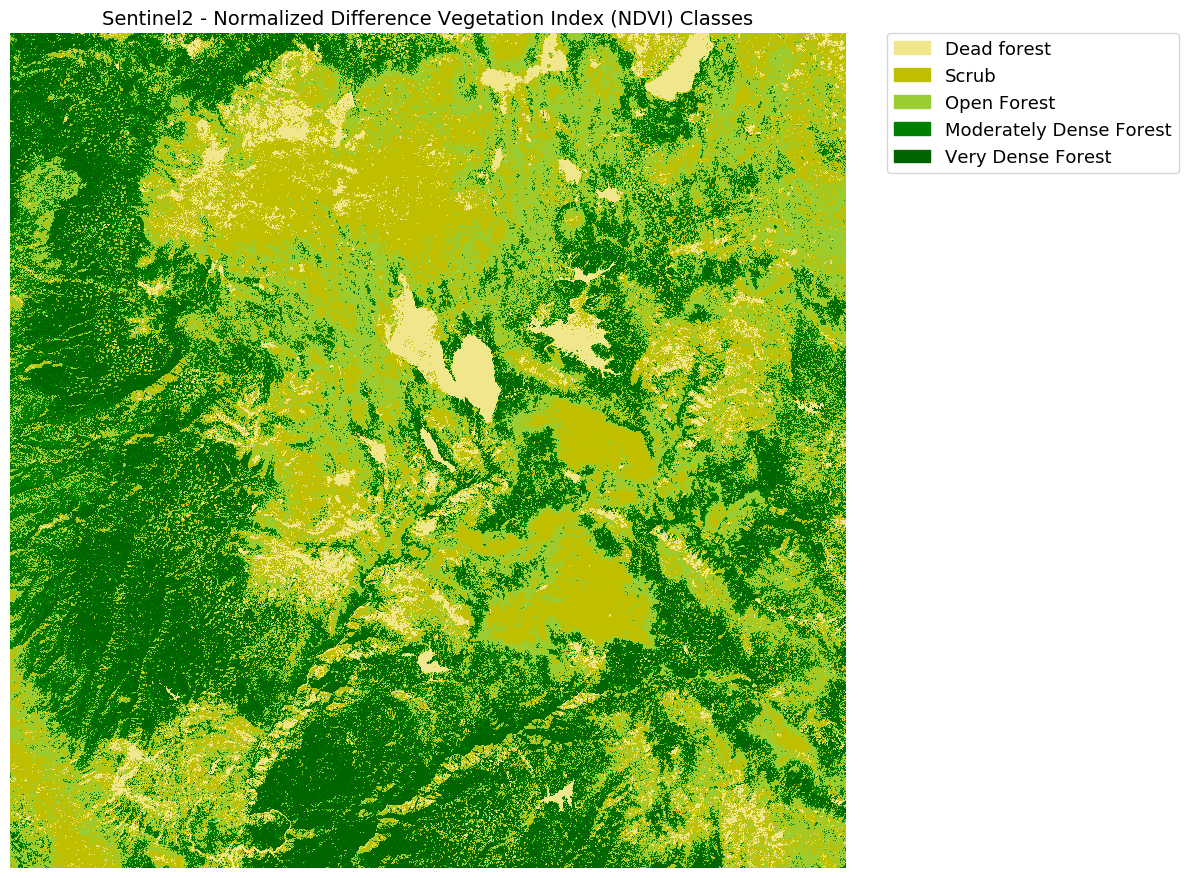

In [17]:
aws_session = AWSSession(boto3.Session(), requester_pays=True)
with rio.Env(aws_session):
    with rio.open('s3://sentinel-s2-l1c/tiles/10/T/FK/2019/1/10/0/B04.jp2') as src1:
        red = src1.read()
    with rio.open('s3://sentinel-s2-l1c/tiles/10/T/FK/2019/1/10/0/B08.jp2') as src2:
        nir = src2.read()
    ndvisample = (nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float))
    #ep.plot_bands(ndvisample, cmap="RdYlGn", vmin=-1, vmax=1);
    
ndvi_density_class = np.digitize(ndvisample, ndvi_class_bins)
# Apply the nodata mask to the newly classified NDVI data
ndvi_density_class = np.ma.masked_where(
    np.ma.getmask(ndvisample), ndvi_density_class
)
np.unique(ndvi_density_class)

# Get list of classes
classes = np.unique(ndvi_density_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:5]

# Plot your data
fig, (ax1) = plt.subplots(1, figsize=(12, 12),num=1, clear=True)
im1 = ax1.imshow(np.squeeze(ndvi_density_class), cmap=nbr_cmap)
ep.draw_legend(im_ax=im1, classes=classes, titles=ndvi_cat_names)
ax1.set_title(
    "Sentinel2 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)

ax1.set_axis_off()
plt.tight_layout()

We will apply similar transformation to images in Lambda funtion that we created in previous steps

## Clean Up (Optional)

Though we did not create any AWS billable resources as part of this exercise, the geographic and GIS data that we downloaded and the images generated may take up significant storage. Make sure to check any storage utilization and delete the files as needed. 